In [1]:
from scipy.sparse import dia_matrix

import networkx as nx
from networkx import shortest_path_length as nx_path

import numpy as np
import random as rand
import itertools
import statistics as stats

import matplotlib.pyplot as plt
from pprint import pprint

from sys import maxsize

np.set_printoptions(threshold=maxsize)

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
""" all simulation and label functions return ([label-vector], runtime) """


def simulateInfection(G, src, model="SI", lamda=0.3, threshold=0.3):
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    infected_nodes = {src}

    runtime = 0
    for t in itertools.count(0):
        temp_infected = infected_nodes.copy()

        for node in infected_nodes:
            for neighbour in all_neighbors(G, node):
                if random() < lamda:
                    temp_infected.add(neighbour)

        infected_nodes = temp_infected

        if len(infected_nodes) > threshold * N:
            runtime = t
            break

    y = full(N, -1)
    for infNode in infected_nodes:
        y[nodes.index(infNode)] = 1

    return y, runtime

<IPython.core.display.Javascript object>

In [3]:
def labelRankingScore(G, y, alpha=0.5):
    N = G.number_of_nodes()

    W = nx.adjacency_matrix(G)
    diag_elem = W.sum(axis=1).A1 ** (-0.5)

    inv_sqrt_D = dia_matrix((diag_elem, [0]), shape=W.get_shape())
    S = inv_sqrt_D @ W @ inv_sqrt_D

    f = np.copy(y)

    runtime = 0
    for t in itertools.count(0):
        f_ = alpha * S @ f + (1 - alpha) * y

        if np.linalg.norm(f - f_) < 0.001 * N:  # Convergence Criteria
            runtime = t
            break

        f = f_

    return f, runtime

<IPython.core.display.Javascript object>

In [4]:
""" known_dicts = [ {infected: [nodes], safe: [nodes]} ] """


def simulatePartialInfection(
    G, src, model="SI", lamda=0.3, threshold=0.3, sampling=0.7, n_snaps=1
):
    N = G.number_of_nodes()
    nodes = list(G.nodes())
    infected = {src}

    runtime = 0
    for t in itertools.count(0):
        temp_infected = infected.copy()

        for node in infected:
            for neighbour in nx.all_neighbors(G, node):
                if rand.random() < lamda:
                    temp_infected.add(neighbour)

        infected = temp_infected

        if len(infected) > threshold * N:
            runtime = t
            break

    snapshots = [rand.sample(nodes, int(sampling * N)) for _ in range(n_snaps)]
    known_dicts = [{"infected": [], "safe": []} for _ in range(n_snaps)]

    for i, snapshot in enumerate(snapshots):
        for node in snapshot:
            known_dicts[i]["infected" if node in infected else "safe"].append(node)

    return known_dicts, runtime

<IPython.core.display.Javascript object>

In [5]:
def resetF(F, known_dict):
    for node in known_dict["safe"]:
        F[node][0] = 1
        F[node][1] = 0

    for node in known_dict["infected"]:
        F[node][0] = 0
        F[node][1] = 1


def GFHF(G, known_dict):
    N = G.number_of_nodes()
    W = nx.adjacency_matrix(G)

    diag_elem = 1 / W.sum(axis=1).A1
    inv_D = dia_matrix((diag_elem, [0]), shape=W.get_shape())

    P = inv_D @ W
    F = np.zeros((N, 2))

    resetF(F, known_dict)

    runtime = 0
    for t in itertools.count(0):
        F_ = P @ F
        curr_diff = sum(sum(abs(F - F_)))

        resetF(F, known_dict)

        if curr_diff < 0.0001 * N:  # Convergence Criteria
            runtime = t
            break

        F = F_

    O = np.array([1 if f[1] > f[0] else -1 for f in F])
    return O, runtime


def LGC(G, known_dict, alpha):
    N = G.number_of_nodes()
    W = nx.adjacency_matrix(G)

    diag_elem = W.sum(axis=1).A1 ** (-0.5)
    inv_sqrt_D = dia_matrix((diag_elem, [0]), shape=W.get_shape())

    S = inv_sqrt_D @ W @ inv_sqrt_D
    F = np.zeros((N, 2))

    resetF(F, known_dict)
    Y = np.copy(F)

    runtime = 0
    for t in itertools.count(0):
        F_ = alpha * S @ F + (1 - alpha) * Y

        if sum(sum(abs(F - F_))) < 0.0001 * N:  # Convergence Criterion
            runtime = t
            break

        F = F_

    O = np.array([1 if f[1] > f[0] else -1 for f in F])
    return O, runtime

<IPython.core.display.Javascript object>

In [6]:
def detected_src(G, f):
    src_idx = max(enumerate(f), key=lambda x: x[1])
    src = list(G.nodes())[src_idx[0]]
    return src

<IPython.core.display.Javascript object>

In [7]:
""" Generate avg hops for a specific graph_type and variations(var) are nodes/sample """


def gen_graph_data(graph_gen, data_var, type_var):
    GFHF_hops = []
    LGC_hops = []

    for data in data_var:

        if type_var == "nodes":
            G = graph_gen(n=data)
            src = rand.choice(list(G.nodes()))
            N = G.number_of_nodes()

            known_dicts, sim_time = simulatePartialInfection(
                G, src, threshold=0.3, sampling=0.2, n_snaps=10
            )
        elif type_var == "sample":
            G = graph_gen(n=2000)
            src = rand.choice(list(G.nodes()))
            N = G.number_of_nodes()

            known_dicts, sim_time = simulatePartialInfection(
                G, src, threshold=0.3, sampling=data, n_snaps=10
            )

        # Return is [ ([], time) ]
        GFHF_pred_time = [GFHF(G, labelled) for labelled in known_dicts]
        LGC_pred_time = [LGC(G, labelled, alpha=0.5) for labelled in known_dicts]

        GFHF_label_time = [labelRankingScore(G, y) for (y, t) in GFHF_pred_time]
        LGC_label_time = [labelRankingScore(G, y) for (y, t) in LGC_pred_time]

        # Return is [ dist actual_src -> predicted_src ]
        GFHF_src_hop = [
            nx_path(G, src, detected_src(G, f)) for (f, t) in GFHF_label_time
        ]
        LGC_src_hop = [nx_path(G, src, detected_src(G, f)) for (f, t) in LGC_label_time]

        GFHF_hops.append(stats.mean(GFHF_src_hop))
        LGC_hops.append(stats.mean(LGC_src_hop))

    return GFHF_hops, LGC_hops


def plot_graph(x_label, x, *ys):
    font_opt = {"fontsize": 16, "weight": "light"}

    fig, ax = plt.subplots(1, 1, figsize=(18, 5))

    for y in ys:
        ax.plot(x, y)

    #     ax1.plot(x_n_nodes, LGC_hops)
    ax.set_xlabel(x_label, font_opt)
    ax.set_ylabel("Avg Hops", font_opt)

    #     fig.text(0.5, 1, "Hops-Nodes", {"fontsize": 22})

    plt.show()

<IPython.core.display.Javascript object>

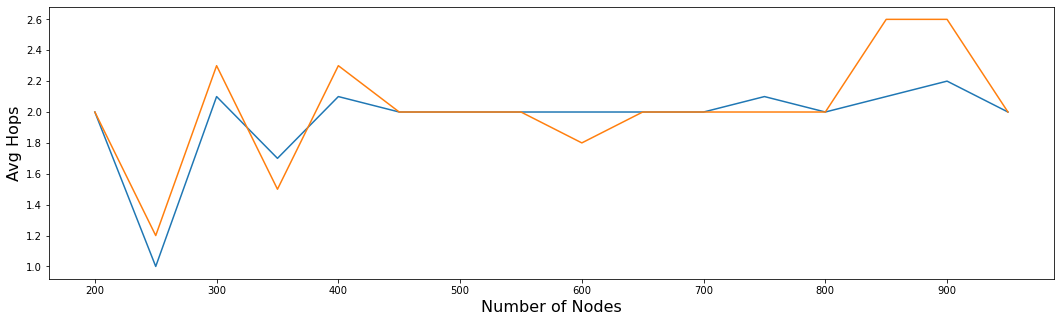

<IPython.core.display.Javascript object>

In [10]:
from functools import partial

graph_gen = partial(nx.random_graphs.barabasi_albert_graph, m=8)
x_nodes = np.arange(200, 1000, 50)

GFHF_hops, LGC_hops = gen_graph_data(graph_gen, x_nodes, "nodes")
plot_graph("Number of Nodes", x_nodes, GFHF_hops, LGC_hops)

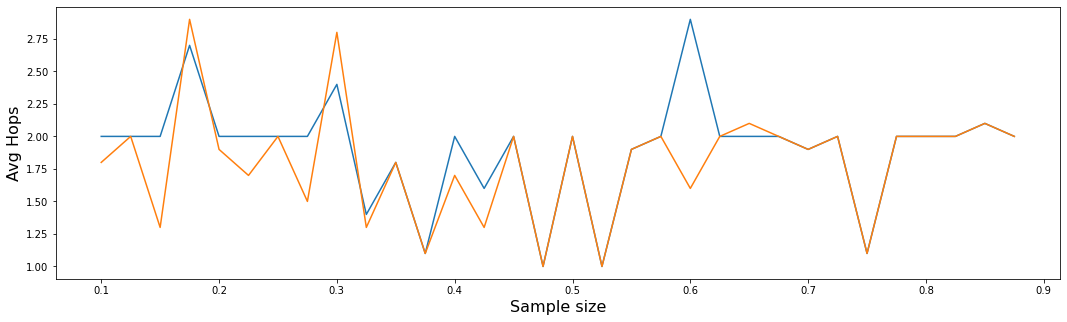

<IPython.core.display.Javascript object>

In [11]:
graph_gen = partial(nx.random_graphs.barabasi_albert_graph, m=8)
x_sampling = np.arange(0.1, 0.9, 0.025)

GFHF_hops, LGC_hops = gen_graph_data(graph_gen, x_sampling, "sample")
plot_graph("Sample size", x_sampling, GFHF_hops, LGC_hops)